In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = True
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-10-27 11:32:29.385777: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-10-27 11:32:35.589047: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-10-27 11:32:35.634610: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-10-27 11:32:35.634645: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-10-27 11:32:35.636640: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-10-27 11:32:35.638617: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Parameters estimation

In [2]:
import os

In [3]:
dataset = TINN_Single_Sim_Dataset(os.path.abspath("../../test/outputs_Brusselator_100_by_100/Brusselator_1"),
                                 "Brusselator_1",
                                 thining_start=-2)

In [4]:
#layers = [5, 128, 128, 128, 128, 2]
layers = [3, 256, 256, 256, 256, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
pinn2 = tu.NN(layers, dataset.lb, dataset.ub, dtype=tf.float64)
pde_loss2 = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulation.Ds[0],dtype=pinn2.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulation.Ds[1],dtype=pinn2.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn2.dtype),
                       A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinn2.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       #B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn2.dtype)
                       B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinn2.dtype) 
                       #B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

l2_norm2 = L2()
l_inf_norm2 = L_Inf()

In [6]:
model2 = tu.TINN(pinn2, 
                pde_loss2, 
                loss = l2_norm2+ l_inf_norm2,
                #non_zero_loss=pde_non_zero, 
                alpha = 0.2,
                loss_penalty_power=1,
                print_precision=".10f")

In [7]:
dataset = dataset.cache()

In [8]:
dataset.x_size

20000

In [9]:
results2_1 = model2.train(epochs=10000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=100,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 10
                     )


Start of epoch 0


2022-10-27 11:34:58.237027: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-27 11:35:15.529714: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 4.2755866051
total loss: 18.4843016531, total regularisd loss (sum of batches): 73.9372066122
obs u loss: 14.1873504350, obs v loss: 2.9149959102
pde u loss: 1.1943663805, pde v loss: 0.1875889273
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000
A: 0.99826 B: 0.99824 
Time taken: 40.01s

Start of epoch 100
Training observations acc over epoch: 1.7244898081
total loss: 8.2170104385, total regularisd loss (sum of batches): 99.2933400799
obs u loss: 6.3297279557, obs v loss: 0.5682313811
pde u loss: 0.1331658742, pde v loss: 1.1858852276
lambda obs u: 3.9104207081, lambda obs v: 0.0673490833
lambda pde u: 0.0090354304, lambda pde v: 0.0131947781
A: 1.00208 B: 1.01426 
Time taken: 81.25s

Start of epoch 200
Training observations acc over epoch: 1.7216845751
total loss: 8.1501199719, total regularisd loss (sum of batches): 99.3797660687
obs u loss: 6.3272889352, obs v loss: 0.5594496385
pde u 


Start of epoch 1900
Training observations acc over epoch: 0.0930618569
total loss: 3.4861375864, total regularisd loss (sum of batches): 6.5380172385
obs u loss: 0.2229539581, obs v loss: 0.1492934809
pde u loss: 1.4706553479, pde v loss: 1.6432347995
lambda obs u: 2.6578184640, lambda obs v: 0.7364392168
lambda pde u: 0.2997885374, lambda pde v: 0.3059537818
A: 1.67601 B: 2.05938 
Time taken: 56.95s

Start of epoch 2000
Training observations acc over epoch: 0.0827572420
total loss: 3.1439984186, total regularisd loss (sum of batches): 5.9809451164
obs u loss: 0.2059896882, obs v loss: 0.1250392646
pde u loss: 1.3391396361, pde v loss: 1.4738298297
lambda obs u: 2.5934940767, lambda obs v: 0.7700512589
lambda pde u: 0.3100860185, lambda pde v: 0.3263686459
A: 1.72283 B: 2.13329 
Time taken: 56.95s

Start of epoch 2100
Training observations acc over epoch: 0.0811640471
total loss: 2.9825686022, total regularisd loss (sum of batches): 6.3284952866
obs u loss: 0.2227257768, obs v loss: 0


Start of epoch 4000
Training observations acc over epoch: 0.0382660367
total loss: 1.9063644464, total regularisd loss (sum of batches): 2.4265939798
obs u loss: 0.1038926755, obs v loss: 0.0491714802
pde u loss: 0.8641027979, pde v loss: 0.8891974928
lambda obs u: 1.3374942348, lambda obs v: 2.2313330500
lambda pde u: 0.1770776772, lambda pde v: 0.2540950380
A: 2.01737 B: 2.72842 
Time taken: 56.98s

Start of epoch 4100
Training observations acc over epoch: 0.0374771915
total loss: 1.8514473800, total regularisd loss (sum of batches): 2.3199844900
obs u loss: 0.1015086925, obs v loss: 0.0484000640
pde u loss: 0.8422691856, pde v loss: 0.8592694379
lambda obs u: 1.4510863887, lambda obs v: 2.1781713296
lambda pde u: 0.1513223363, lambda pde v: 0.2194199454
A: 2.03174 B: 2.74353 
Time taken: 56.94s

Start of epoch 4200
Training observations acc over epoch: 1.8329480886
total loss: 10.6545426934, total regularisd loss (sum of batches): 52.6071366286
obs u loss: 6.6265773127, obs v loss:


Start of epoch 6100
Training observations acc over epoch: 0.0748567507
total loss: 4.4330095671, total regularisd loss (sum of batches): 5.4162933219
obs u loss: 0.2280381978, obs v loss: 0.0713888056
pde u loss: 2.1787715855, pde v loss: 1.9548109782
lambda obs u: 3.5822964667, lambda obs v: 0.1607774215
lambda pde u: 0.0926114800, lambda pde v: 0.1643146319
A: 2.05810 B: 2.69920 
Time taken: 57.01s

Start of epoch 6200
Training observations acc over epoch: 0.0419442765
total loss: 3.7523510005, total regularisd loss (sum of batches): 3.9859087675
obs u loss: 0.1082054585, obs v loss: 0.0595716429
pde u loss: 1.7786307389, pde v loss: 1.8059431603
lambda obs u: 3.3501292659, lambda obs v: 0.2975939518
lambda pde u: 0.1438580264, lambda pde v: 0.2084187559
A: 2.07365 B: 2.69556 
Time taken: 57.00s

Start of epoch 6300
Training observations acc over epoch: 0.0333440043
total loss: 3.1807761985, total regularisd loss (sum of batches): 3.4696969574
obs u loss: 0.0797304997, obs v loss: 0


Start of epoch 8200
Training observations acc over epoch: 0.0800004825
total loss: 4.0963981517, total regularisd loss (sum of batches): 5.8133934969
obs u loss: 0.2540705753, obs v loss: 0.0659313481
pde u loss: 1.9313553874, pde v loss: 1.8450408410
lambda obs u: 3.5681092341, lambda obs v: 0.1461508155
lambda pde u: 0.0884007855, lambda pde v: 0.1973391648
A: 1.75566 B: 2.79454 
Time taken: 56.96s

Start of epoch 8300
Training observations acc over epoch: 0.0458582118
total loss: 3.3628627598, total regularisd loss (sum of batches): 3.7880702885
obs u loss: 0.1200404028, obs v loss: 0.0633924489
pde u loss: 1.5779794643, pde v loss: 1.6014504439
lambda obs u: 3.4392629669, lambda obs v: 0.2295542215
lambda pde u: 0.1213873791, lambda pde v: 0.2097954324
A: 1.76181 B: 2.78766 
Time taken: 56.96s

Start of epoch 8400
Training observations acc over epoch: 0.0355944037
total loss: 2.7510550061, total regularisd loss (sum of batches): 3.1567503445
obs u loss: 0.0802151848, obs v loss: 0

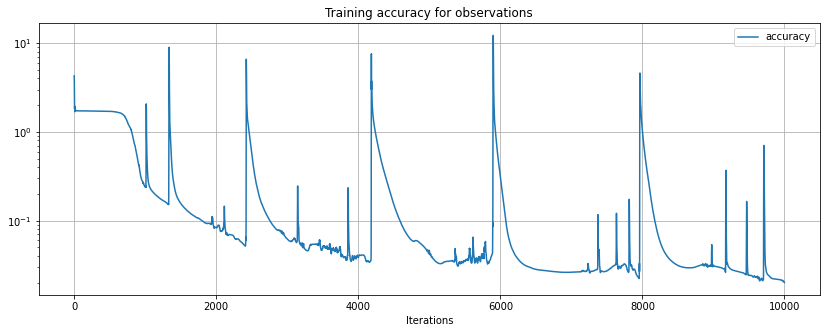

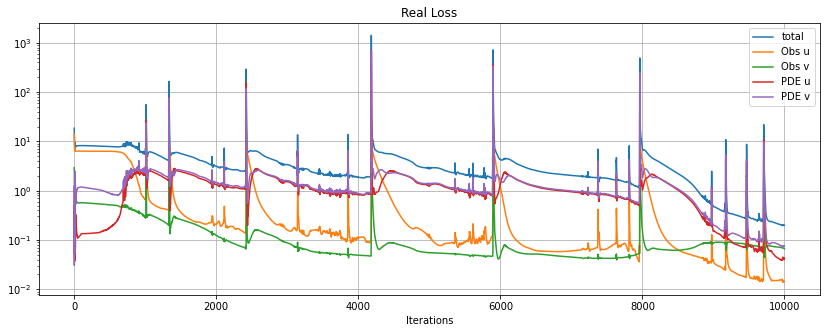

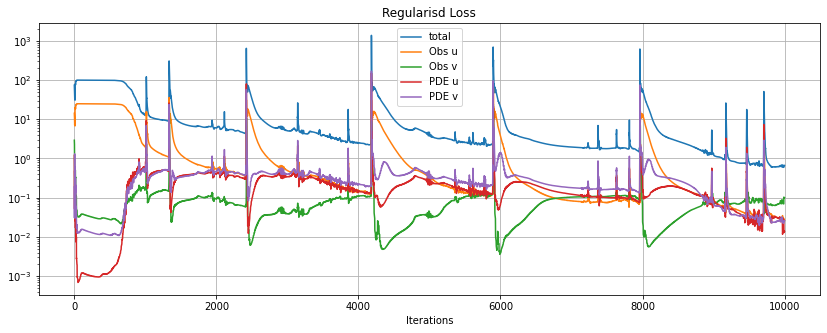

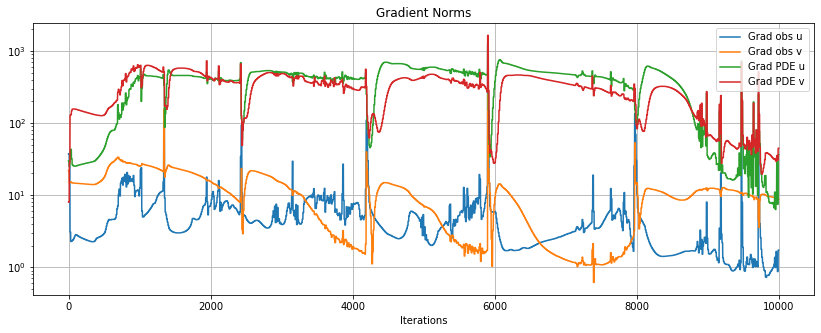

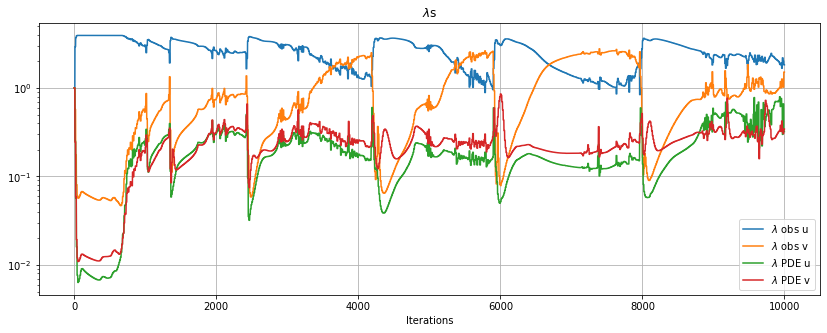

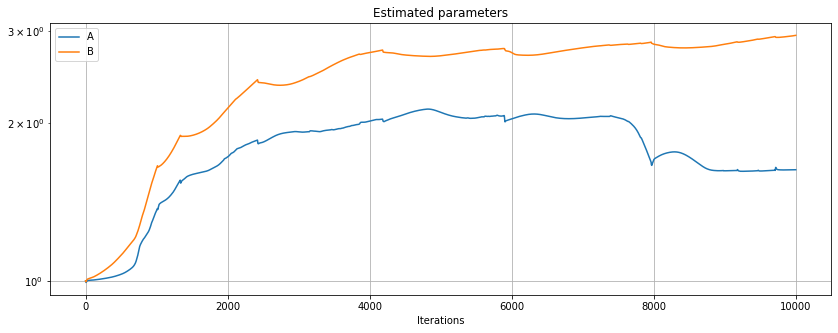

In [10]:
plot_result(results2_1, param_names=["A", "B"])

In [38]:
model2.alpha.assign(.5)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=0.5>

In [39]:
results2_2 = model2.train(epochs=5000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=100,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 5
                     )


Start of epoch 0
Training observations acc over epoch: 0.0200595651
total loss: 0.1983016470, total regularisd loss (sum of batches): 0.6313206540
obs u loss: 0.0143013102, obs v loss: 0.0659369427
pde u loss: 0.0431503574, pde v loss: 0.0749130367
lambda obs u: 1.8235337162, lambda obs v: 1.2242546989
lambda pde u: 0.6392858422, lambda pde v: 0.3129257427
A: 1.62873 B: 2.94294 
Time taken: 1.60s

Start of epoch 100
Training observations acc over epoch: 0.0186199192
total loss: 0.1855310109, total regularisd loss (sum of batches): 0.6016312756
obs u loss: 0.0135622850, obs v loss: 0.0609173832
pde u loss: 0.0425684091, pde v loss: 0.0684829336
lambda obs u: 1.8649768200, lambda obs v: 1.4176415518
lambda pde u: 0.3793568031, lambda pde v: 0.3380248251
A: 1.63094 B: 2.96169 
Time taken: 67.21s

Start of epoch 200
Training observations acc over epoch: 0.0165105797
total loss: 0.2021630643, total regularisd loss (sum of batches): 0.6586358173
obs u loss: 0.0144860697, obs v loss: 0.05155


Start of epoch 2100
Training observations acc over epoch: 0.0304858182
total loss: 0.6825951816, total regularisd loss (sum of batches): 1.6696328505
obs u loss: 0.0478263387, obs v loss: 0.0741169312
pde u loss: 0.2407803289, pde v loss: 0.3198715827
lambda obs u: 1.9920881645, lambda obs v: 1.3005574509
lambda pde u: 0.3811875129, lambda pde v: 0.3261668716
A: 1.71639 B: 3.06608 
Time taken: 68.33s

Start of epoch 2200
Training observations acc over epoch: 0.0224121865
total loss: 0.2701690939, total regularisd loss (sum of batches): 0.7218524826
obs u loss: 0.0179958172, obs v loss: 0.0716529270
pde u loss: 0.0731270303, pde v loss: 0.1073933193
lambda obs u: 2.3234878704, lambda obs v: 0.9463402937
lambda pde u: 0.3696873846, lambda pde v: 0.3604844512
A: 1.71802 B: 3.07620 
Time taken: 68.34s

Start of epoch 2300
Training observations acc over epoch: 0.0207859967
total loss: 0.2165639011, total regularisd loss (sum of batches): 0.6617451212
obs u loss: 0.0175932587, obs v loss: 0


Start of epoch 4200
Training observations acc over epoch: 0.0051961672
total loss: 0.0655308518, total regularisd loss (sum of batches): 0.2015429760
obs u loss: 0.0063584508, obs v loss: 0.0144262159
pde u loss: 0.0204096537, pde v loss: 0.0243365314
lambda obs u: 1.6926046956, lambda obs v: 1.5849573304
lambda pde u: 0.3454949260, lambda pde v: 0.3769430480
A: 1.74387 B: 3.20871 
Time taken: 68.33s

Start of epoch 4300
Training observations acc over epoch: 0.0046924017
total loss: 0.0651466260, total regularisd loss (sum of batches): 0.1883392042
obs u loss: 0.0062726525, obs v loss: 0.0124969551
pde u loss: 0.0202347433, pde v loss: 0.0261422751
lambda obs u: 1.6355530956, lambda obs v: 1.7229734063
lambda pde u: 0.2784292162, lambda pde v: 0.3630442819
A: 1.74529 B: 3.21260 
Time taken: 68.35s

Start of epoch 4400
Training observations acc over epoch: 0.3532063961
total loss: 4.5965069007, total regularisd loss (sum of batches): 15.9464034934
obs u loss: 1.3700060997, obs v loss: 

In [40]:
print(f"A = {pde_loss2.A.tf_var.numpy()[0]:.16f}")
print(f"B = {pde_loss2.B.tf_var.numpy()[0]:.16f}")

A = 1.7446256144110164
B = 3.2251271188490227


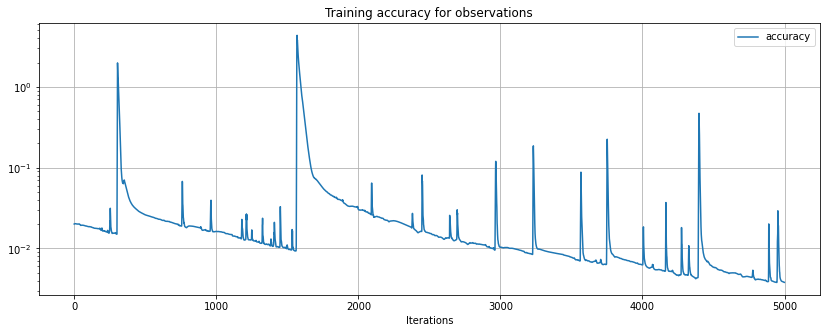

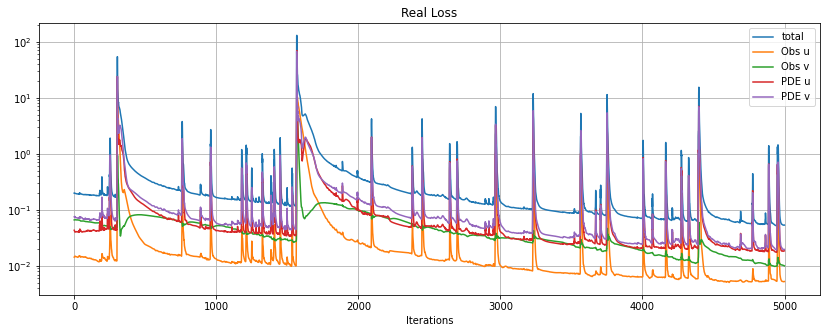

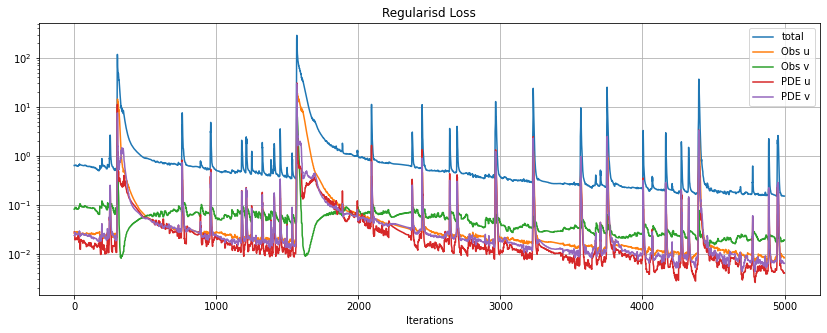

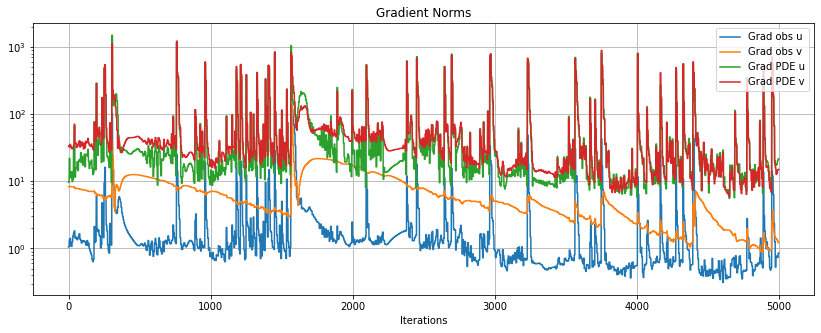

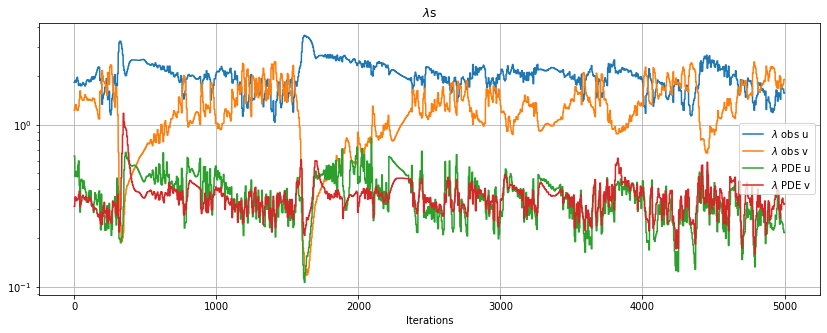

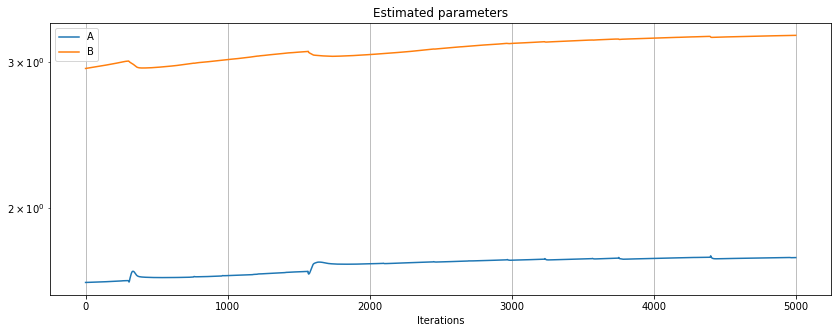

In [65]:
plot_result(results2_2, param_names=["A", "B"])

In [11]:
print(f"A = {pde_loss2.A.tf_var.numpy()[0]:.16f}")
print(f"B = {pde_loss2.B.tf_var.numpy()[0]:.16f}")

A = 1.6286998589248838
B = 2.9427490294012517


In [66]:
model2.alpha.assign(.99)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=0.99>

In [68]:
model2.optimizer.lr.assign(2.5e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.00025>

In [69]:
results2_3 = model2.train(epochs=1000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=20,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 1
                     )


Start of epoch 0
Training observations acc over epoch: 0.0038064322
total loss: 0.0532897401, total regularisd loss (sum of batches): 0.1505338711
obs u loss: 0.0052783328, obs v loss: 0.0099473975
pde u loss: 0.0185256292, pde v loss: 0.0195383805
lambda obs u: 1.4442045163, lambda obs v: 2.0563921390
lambda pde u: 0.2002535153, lambda pde v: 0.2991498294
A: 1.74462 B: 3.22515 
Time taken: 1.60s

Start of epoch 20
Training observations acc over epoch: 0.0037063293
total loss: 0.0514182629, total regularisd loss (sum of batches): 0.1455456308
obs u loss: 0.0051224512, obs v loss: 0.0097028658
pde u loss: 0.0174665406, pde v loss: 0.0191264053
lambda obs u: 1.5483862171, lambda obs v: 1.9187694065
lambda pde u: 0.2296701363, lambda pde v: 0.3031742401
A: 1.74477 B: 3.22545 
Time taken: 31.07s

Start of epoch 40
Training observations acc over epoch: 0.0036619934
total loss: 0.0509710184, total regularisd loss (sum of batches): 0.1418889582
obs u loss: 0.0050224015, obs v loss: 0.0096255


Start of epoch 420
Training observations acc over epoch: 0.0029432785
total loss: 0.0488813871, total regularisd loss (sum of batches): 0.1134659480
obs u loss: 0.0041741662, obs v loss: 0.0075989475
pde u loss: 0.0173660443, pde v loss: 0.0197422292
lambda obs u: 1.7553567799, lambda obs v: 1.8836497540
lambda pde u: 0.1674825668, lambda pde v: 0.1935108993
A: 1.74748 B: 3.22989 
Time taken: 31.90s

Start of epoch 440
Training observations acc over epoch: 0.0028926479
total loss: 0.0490961965, total regularisd loss (sum of batches): 0.1124457022
obs u loss: 0.0041686013, obs v loss: 0.0074019905
pde u loss: 0.0175107867, pde v loss: 0.0200148180
lambda obs u: 1.6983049174, lambda obs v: 1.9528492379
lambda pde u: 0.1608947769, lambda pde v: 0.1879510677
A: 1.74764 B: 3.23012 
Time taken: 31.90s

Start of epoch 460
Training observations acc over epoch: 0.0028415381
total loss: 0.0493396275, total regularisd loss (sum of batches): 0.1112887917
obs u loss: 0.0041642771, obs v loss: 0.00


Start of epoch 840
Training observations acc over epoch: 0.0021471295
total loss: 0.0520676979, total regularisd loss (sum of batches): 0.0899885867
obs u loss: 0.0043850735, obs v loss: 0.0042034447
pde u loss: 0.0216558404, pde v loss: 0.0218233394
lambda obs u: 0.9422656897, lambda obs v: 2.7453557939
lambda pde u: 0.1403041649, lambda pde v: 0.1720743515
A: 1.75101 B: 3.23115 
Time taken: 31.90s

Start of epoch 860
Training observations acc over epoch: 0.0021103395
total loss: 0.0448083376, total regularisd loss (sum of batches): 0.0823273616
obs u loss: 0.0043958343, obs v loss: 0.0040455230
pde u loss: 0.0175053405, pde v loss: 0.0188616398
lambda obs u: 0.9092967352, lambda obs v: 2.8037765534
lambda pde u: 0.1304237029, lambda pde v: 0.1565030085
A: 1.75117 B: 3.23091 
Time taken: 31.90s

Start of epoch 880
Training observations acc over epoch: 0.0020700123
total loss: 0.0434104935, total regularisd loss (sum of batches): 0.0800151488
obs u loss: 0.0043662330, obs v loss: 0.00

In [85]:
model2.optimizer.lr.assign(1e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [86]:
results2_4 = model2.train(epochs=3000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=20,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 1
                     )


Start of epoch 0
Training observations acc over epoch: 0.0018430043
total loss: 0.0455092351, total regularisd loss (sum of batches): 0.0698456420
obs u loss: 0.0043033469, obs v loss: 0.0031999133
pde u loss: 0.0175704571, pde v loss: 0.0204355178
lambda obs u: 0.8414167725, lambda obs v: 2.9231955479
lambda pde u: 0.1129955384, lambda pde v: 0.1223921412
A: 1.75236 B: 3.22826 
Time taken: 34.94s

Start of epoch 20
Training observations acc over epoch: 0.0018282665
total loss: 0.0402188037, total regularisd loss (sum of batches): 0.0688282955
obs u loss: 0.0041241448, obs v loss: 0.0031889220
pde u loss: 0.0154965305, pde v loss: 0.0174092064
lambda obs u: 0.8936813737, lambda obs v: 2.8313747602
lambda pde u: 0.1353569405, lambda pde v: 0.1395869256
A: 1.75243 B: 3.22805 
Time taken: 46.01s

Start of epoch 40
Training observations acc over epoch: 0.0018157234
total loss: 0.0397277013, total regularisd loss (sum of batches): 0.0697167099
obs u loss: 0.0040694529, obs v loss: 0.003193


Start of epoch 420
Training observations acc over epoch: 0.0015670561
total loss: 0.0325527952, total regularisd loss (sum of batches): 0.0625381941
obs u loss: 0.0035216986, obs v loss: 0.0027465255
pde u loss: 0.0133276221, pde v loss: 0.0129569490
lambda obs u: 1.1796856693, lambda obs v: 2.4589895447
lambda pde u: 0.1722178091, lambda pde v: 0.1891069769
A: 1.75406 B: 3.22341 
Time taken: 31.89s

Start of epoch 440
Training observations acc over epoch: 0.0015597779
total loss: 0.0321065431, total regularisd loss (sum of batches): 0.0633287544
obs u loss: 0.0035116095, obs v loss: 0.0027275020
pde u loss: 0.0131690527, pde v loss: 0.0126983789
lambda obs u: 1.2030946979, lambda obs v: 2.4069479920
lambda pde u: 0.1886054816, lambda pde v: 0.2013518286
A: 1.75414 B: 3.22314 
Time taken: 31.89s

Start of epoch 460
Training observations acc over epoch: 0.0015756104
total loss: 0.0332281573, total regularisd loss (sum of batches): 0.0631454131
obs u loss: 0.0036022173, obs v loss: 0.00


Start of epoch 840
Training observations acc over epoch: 0.0013043875
total loss: 0.0284831909, total regularisd loss (sum of batches): 0.0497816264
obs u loss: 0.0031460411, obs v loss: 0.0020715088
pde u loss: 0.0113484665, pde v loss: 0.0119171746
lambda obs u: 1.1521321389, lambda obs v: 2.5411570983
lambda pde u: 0.1560996538, lambda pde v: 0.1506111090
A: 1.75576 B: 3.21619 
Time taken: 31.90s

Start of epoch 860
Training observations acc over epoch: 0.0013193060
total loss: 0.0313915653, total regularisd loss (sum of batches): 0.0512278586
obs u loss: 0.0032236759, obs v loss: 0.0020535479
pde u loss: 0.0126647230, pde v loss: 0.0134496184
lambda obs u: 1.1449707863, lambda obs v: 2.5600755995
lambda pde u: 0.1504148697, lambda pde v: 0.1445387446
A: 1.75583 B: 3.21583 
Time taken: 31.91s

Start of epoch 880
Training observations acc over epoch: 0.0012840483
total loss: 0.0279957678, total regularisd loss (sum of batches): 0.0487163625
obs u loss: 0.0031097203, obs v loss: 0.00


Start of epoch 1260
Training observations acc over epoch: 0.0011491112
total loss: 0.0265908966, total regularisd loss (sum of batches): 0.0458844971
obs u loss: 0.0028694812, obs v loss: 0.0017269636
pde u loss: 0.0109290884, pde v loss: 0.0110653633
lambda obs u: 1.2832951127, lambda obs v: 2.3840032717
lambda pde u: 0.1702997406, lambda pde v: 0.1624018750
A: 1.75685 B: 3.20959 
Time taken: 31.89s

Start of epoch 1280
Training observations acc over epoch: 0.0011319278
total loss: 0.0243387020, total regularisd loss (sum of batches): 0.0441110387
obs u loss: 0.0028182687, obs v loss: 0.0017094424
pde u loss: 0.0097202363, pde v loss: 0.0100907547
lambda obs u: 1.3090992564, lambda obs v: 2.3567215515
lambda pde u: 0.1718306703, lambda pde v: 0.1623485217
A: 1.75689 B: 3.20932 
Time taken: 31.89s

Start of epoch 1300
Training observations acc over epoch: 0.0011478020
total loss: 0.0292354924, total regularisd loss (sum of batches): 0.0472664709
obs u loss: 0.0028902846, obs v loss: 0


Start of epoch 1680
Training observations acc over epoch: 0.0010759598
total loss: 0.0289809526, total regularisd loss (sum of batches): 0.0445128921
obs u loss: 0.0028274110, obs v loss: 0.0014764281
pde u loss: 0.0124022219, pde v loss: 0.0122748916
lambda obs u: 1.2815416736, lambda obs v: 2.3985829207
lambda pde u: 0.1673810809, lambda pde v: 0.1524943248
A: 1.75751 B: 3.20423 
Time taken: 31.89s

Start of epoch 1700
Training observations acc over epoch: 0.0009965055
total loss: 0.0214769923, total regularisd loss (sum of batches): 0.0380246947
obs u loss: 0.0025296379, obs v loss: 0.0014563842
pde u loss: 0.0085971609, pde v loss: 0.0088938094
lambda obs u: 1.2916209093, lambda obs v: 2.3925435238
lambda pde u: 0.1643836816, lambda pde v: 0.1514518853
A: 1.75753 B: 3.20399 
Time taken: 31.89s

Start of epoch 1720
Training observations acc over epoch: 0.0010077249
total loss: 0.0240464925, total regularisd loss (sum of batches): 0.0410610828
obs u loss: 0.0025770352, obs v loss: 0


Start of epoch 2100
Training observations acc over epoch: 0.0008907412
total loss: 0.0202200856, total regularisd loss (sum of batches): 0.0341861041
obs u loss: 0.0023058110, obs v loss: 0.0012571539
pde u loss: 0.0082705040, pde v loss: 0.0083866167
lambda obs u: 1.3110931906, lambda obs v: 2.3853316611
lambda pde u: 0.1574399557, lambda pde v: 0.1461351925
A: 1.75796 B: 3.19907 
Time taken: 31.89s

Start of epoch 2120
Training observations acc over epoch: 0.0008870653
total loss: 0.0200536566, total regularisd loss (sum of batches): 0.0347290248
obs u loss: 0.0023002379, obs v loss: 0.0012480235
pde u loss: 0.0080819312, pde v loss: 0.0084234640
lambda obs u: 1.3528405503, lambda obs v: 2.3243249576
lambda pde u: 0.1682979123, lambda pde v: 0.1545365798
A: 1.75798 B: 3.19883 
Time taken: 31.89s

Start of epoch 2140
Training observations acc over epoch: 0.0008861339
total loss: 0.0206455406, total regularisd loss (sum of batches): 0.0343911303
obs u loss: 0.0023049918, obs v loss: 0


Start of epoch 2520
Training observations acc over epoch: 0.0008072476
total loss: 0.0184019170, total regularisd loss (sum of batches): 0.0309812383
obs u loss: 0.0021205796, obs v loss: 0.0011084109
pde u loss: 0.0075320044, pde v loss: 0.0076409220
lambda obs u: 1.3282157376, lambda obs v: 2.3671935484
lambda pde u: 0.1579924272, lambda pde v: 0.1465982868
A: 1.75820 B: 3.19475 
Time taken: 31.90s

Start of epoch 2540
Training observations acc over epoch: 0.0008110370
total loss: 0.0234110767, total regularisd loss (sum of batches): 0.0349775009
obs u loss: 0.0021347252, obs v loss: 0.0011094230
pde u loss: 0.0098273833, pde v loss: 0.0103395452
lambda obs u: 1.3596543514, lambda obs v: 2.3164585783
lambda pde u: 0.1686360901, lambda pde v: 0.1552509802
A: 1.75822 B: 3.19453 
Time taken: 31.90s

Start of epoch 2560
Training observations acc over epoch: 0.0007945910
total loss: 0.0179507928, total regularisd loss (sum of batches): 0.0306162252
obs u loss: 0.0020840877, obs v loss: 0


Start of epoch 2940
Training observations acc over epoch: 0.0007474578
total loss: 0.0170525898, total regularisd loss (sum of batches): 0.0301713202
obs u loss: 0.0019846899, obs v loss: 0.0010051414
pde u loss: 0.0068914155, pde v loss: 0.0071713430
lambda obs u: 1.3919309665, lambda obs v: 2.2514438506
lambda pde u: 0.1877990201, lambda pde v: 0.1688261628
A: 1.75833 B: 3.19115 
Time taken: 31.88s

Start of epoch 2960
Training observations acc over epoch: 0.0007564581
total loss: 0.0181194201, total regularisd loss (sum of batches): 0.0302241395
obs u loss: 0.0020244451, obs v loss: 0.0010013873
pde u loss: 0.0076100569, pde v loss: 0.0074835307
lambda obs u: 1.3496359050, lambda obs v: 2.3200854238
lambda pde u: 0.1732278744, lambda pde v: 0.1570507968
A: 1.75833 B: 3.19098 
Time taken: 31.90s

Start of epoch 2980
Training observations acc over epoch: 0.0007313977
total loss: 0.0161429246, total regularisd loss (sum of batches): 0.0290680920
obs u loss: 0.0019310035, obs v loss: 0

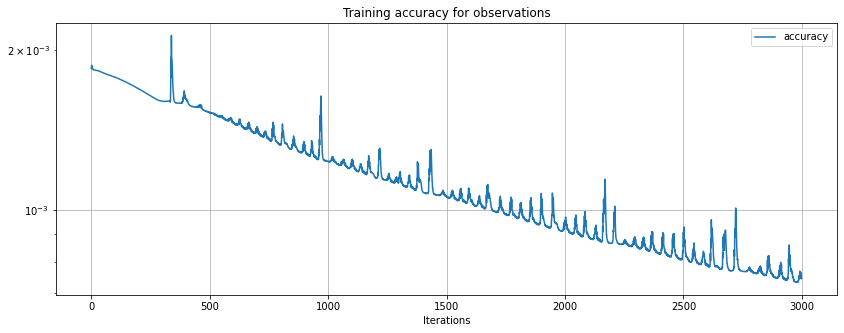

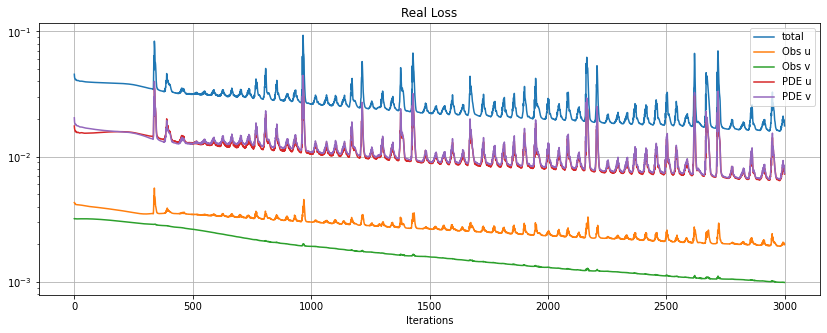

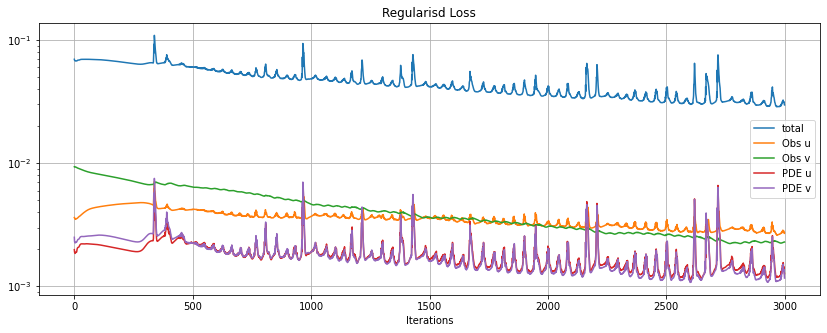

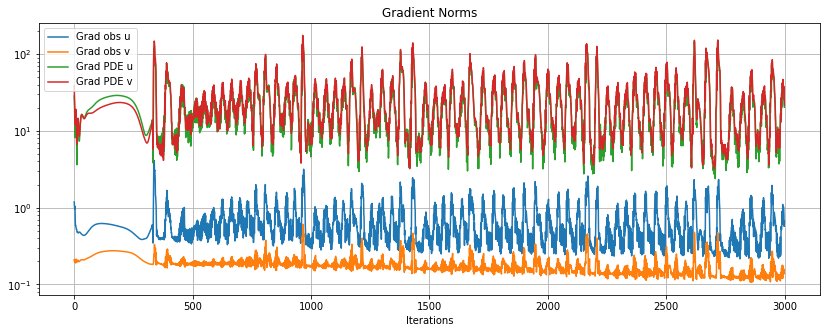

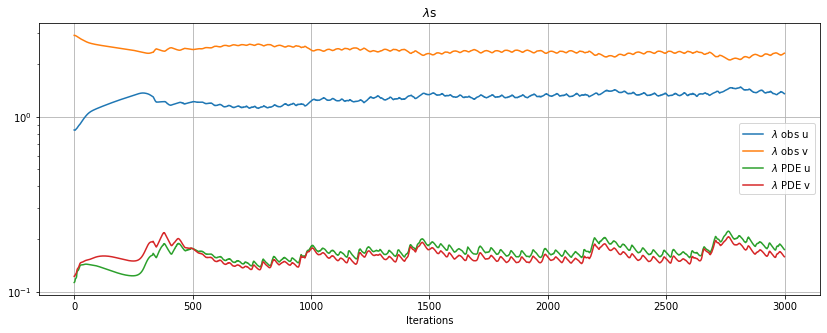

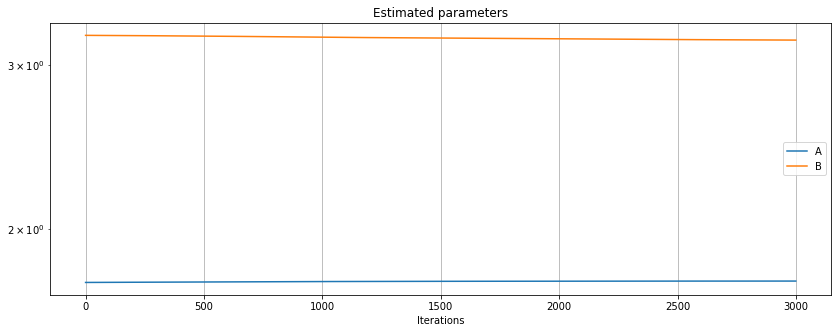

In [100]:
plot_result(results2_4, param_names=["A", "B"])

In [101]:
results2_5 = model2.train(epochs=18000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=100,
                      stop_threshold=9e-6,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 1
                     )


Start of epoch 0
Training observations acc over epoch: 0.0007331134
total loss: 0.0168747987, total regularisd loss (sum of batches): 0.0289311042
obs u loss: 0.0019436439, obs v loss: 0.0009888096
pde u loss: 0.0068553604, pde v loss: 0.0070869848
lambda obs u: 1.3528979476, lambda obs v: 2.3148613174
lambda pde u: 0.1740659996, lambda pde v: 0.1581747354
A: 1.75835 B: 3.19063 
Time taken: 1.65s

Start of epoch 100
Training observations acc over epoch: 0.0007111779
total loss: 0.0156748149, total regularisd loss (sum of batches): 0.0282134045
obs u loss: 0.0018846830, obs v loss: 0.0009600287
pde u loss: 0.0063408254, pde v loss: 0.0064892778
lambda obs u: 1.3634772895, lambda obs v: 2.2742346045
lambda pde u: 0.1889200681, lambda pde v: 0.1733680379
A: 1.75837 B: 3.18977 
Time taken: 157.45s

Start of epoch 200
Training observations acc over epoch: 0.0007052085
total loss: 0.0153192586, total regularisd loss (sum of batches): 0.0291592021
obs u loss: 0.0018718643, obs v loss: 0.0009


Start of epoch 2100
Training observations acc over epoch: 0.0005155957
total loss: 0.0122782750, total regularisd loss (sum of batches): 0.0205572198
obs u loss: 0.0014086600, obs v loss: 0.0006537230
pde u loss: 0.0050777913, pde v loss: 0.0051381006
lambda obs u: 1.3671775320, lambda obs v: 2.2981485724
lambda pde u: 0.1743143373, lambda pde v: 0.1603595584
A: 1.75831 B: 3.17762 
Time taken: 159.53s

Start of epoch 2200
Training observations acc over epoch: 0.0005058830
total loss: 0.0116982616, total regularisd loss (sum of batches): 0.0192701406
obs u loss: 0.0013874244, obs v loss: 0.0006361075
pde u loss: 0.0048484131, pde v loss: 0.0048263166
lambda obs u: 1.3194432358, lambda obs v: 2.3724786047
lambda pde u: 0.1600589737, lambda pde v: 0.1480191858
A: 1.75831 B: 3.17706 
Time taken: 159.54s

Start of epoch 2300
Training observations acc over epoch: 0.0004993035
total loss: 0.0115182088, total regularisd loss (sum of batches): 0.0196993831
obs u loss: 0.0013684298, obs v loss:


Start of epoch 4200
Training observations acc over epoch: 0.0003829511
total loss: 0.0097050011, total regularisd loss (sum of batches): 0.0145627883
obs u loss: 0.0010703554, obs v loss: 0.0004614490
pde u loss: 0.0041774626, pde v loss: 0.0039957341
lambda obs u: 1.2303427394, lambda obs v: 2.4818910382
lambda pde u: 0.1477312322, lambda pde v: 0.1400349902
A: 1.75787 B: 3.16828 
Time taken: 159.48s

Start of epoch 4300
Training observations acc over epoch: 0.0003876560
total loss: 0.0124949373, total regularisd loss (sum of batches): 0.0175665451
obs u loss: 0.0010903016, obs v loss: 0.0004603226
pde u loss: 0.0054672710, pde v loss: 0.0054770422
lambda obs u: 1.2483480023, lambda obs v: 2.4015497037
lambda pde u: 0.1764592627, lambda pde v: 0.1736430313
A: 1.75782 B: 3.16794 
Time taken: 159.47s

Start of epoch 4400
Training observations acc over epoch: 0.0003746706
total loss: 0.0092569533, total regularisd loss (sum of batches): 0.0142096732
obs u loss: 0.0010492432, obs v loss:


Start of epoch 6300
Training observations acc over epoch: 0.0003079525
total loss: 0.0079815347, total regularisd loss (sum of batches): 0.0111754756
obs u loss: 0.0008831225, obs v loss: 0.0003486874
pde u loss: 0.0034215990, pde v loss: 0.0033281257
lambda obs u: 1.0436047373, lambda obs v: 2.6776945055
lambda pde u: 0.1475429345, lambda pde v: 0.1311578228
A: 1.75721 B: 3.16176 
Time taken: 159.47s

Start of epoch 6400
Training observations acc over epoch: 0.0003023525
total loss: 0.0080684681, total regularisd loss (sum of batches): 0.0110259200
obs u loss: 0.0008658074, obs v loss: 0.0003436025
pde u loss: 0.0035131732, pde v loss: 0.0033458849
lambda obs u: 1.0391766903, lambda obs v: 2.6893305331
lambda pde u: 0.1419249706, lambda pde v: 0.1295678060
A: 1.75718 B: 3.16146 
Time taken: 159.51s

Start of epoch 6500
Training observations acc over epoch: 0.0003001396
total loss: 0.0078413231, total regularisd loss (sum of batches): 0.0109718265
obs u loss: 0.0008610941, obs v loss:


Start of epoch 8400
Training observations acc over epoch: 0.0002483020
total loss: 0.0067169745, total regularisd loss (sum of batches): 0.0095067748
obs u loss: 0.0007106243, obs v loss: 0.0002825836
pde u loss: 0.0029324767, pde v loss: 0.0027912899
lambda obs u: 1.1207800886, lambda obs v: 2.5826816927
lambda pde u: 0.1547234845, lambda pde v: 0.1418147341
A: 1.75652 B: 3.15724 
Time taken: 159.46s

Start of epoch 8500
Training observations acc over epoch: 0.0002551006
total loss: 0.0073664741, total regularisd loss (sum of batches): 0.0100373234
obs u loss: 0.0007393775, obs v loss: 0.0002810252
pde u loss: 0.0031989400, pde v loss: 0.0031471314
lambda obs u: 1.1308738383, lambda obs v: 2.5720476357
lambda pde u: 0.1544167479, lambda pde v: 0.1426617781
A: 1.75649 B: 3.15706 
Time taken: 159.46s

Start of epoch 8600
Training observations acc over epoch: 0.0003211321
total loss: 0.0175899194, total regularisd loss (sum of batches): 0.0179843338
obs u loss: 0.0009949558, obs v loss:


Start of epoch 10500
Training observations acc over epoch: 0.0002224010
total loss: 0.0077615126, total regularisd loss (sum of batches): 0.0099369514
obs u loss: 0.0006452916, obs v loss: 0.0002443125
pde u loss: 0.0035531253, pde v loss: 0.0033187833
lambda obs u: 1.1040515340, lambda obs v: 2.5635033978
lambda pde u: 0.1721034962, lambda pde v: 0.1603415719
A: 1.75583 B: 3.15414 
Time taken: 159.49s

Start of epoch 10600
Training observations acc over epoch: 0.0002118175
total loss: 0.0057215472, total regularisd loss (sum of batches): 0.0079110521
obs u loss: 0.0006090599, obs v loss: 0.0002382101
pde u loss: 0.0024968466, pde v loss: 0.0023774306
lambda obs u: 1.0375821340, lambda obs v: 2.6716160328
lambda pde u: 0.1530940941, lambda pde v: 0.1377077390
A: 1.75581 B: 3.15402 
Time taken: 159.45s

Start of epoch 10700
Training observations acc over epoch: 0.0002242568
total loss: 0.0074161538, total regularisd loss (sum of batches): 0.0089595132
obs u loss: 0.0006598057, obs v lo


Start of epoch 12600
Training observations acc over epoch: 0.0001942256
total loss: 0.0082998358, total regularisd loss (sum of batches): 0.0094203338
obs u loss: 0.0005625025, obs v loss: 0.0002143999
pde u loss: 0.0037890427, pde v loss: 0.0037338906
lambda obs u: 1.1316883496, lambda obs v: 2.5570058309
lambda pde u: 0.1637261638, lambda pde v: 0.1475796556
A: 1.75519 B: 3.15171 
Time taken: 159.46s

Start of epoch 12700
Training observations acc over epoch: 0.0002137534
total loss: 0.0104902340, total regularisd loss (sum of batches): 0.0103072995
obs u loss: 0.0006434633, obs v loss: 0.0002115504
pde u loss: 0.0043014294, pde v loss: 0.0053337909
lambda obs u: 1.0508906659, lambda obs v: 2.6693713999
lambda pde u: 0.1476144433, lambda pde v: 0.1321234909
A: 1.75518 B: 3.15161 
Time taken: 159.48s

Start of epoch 12800
Training observations acc over epoch: 0.0002080113
total loss: 0.0070877409, total regularisd loss (sum of batches): 0.0089627307
obs u loss: 0.0006235401, obs v lo


Start of epoch 14700
Training observations acc over epoch: 0.0002092648
total loss: 0.0099866406, total regularisd loss (sum of batches): 0.0108504093
obs u loss: 0.0006431667, obs v loss: 0.0001938925
pde u loss: 0.0042440325, pde v loss: 0.0049055490
lambda obs u: 1.1199909203, lambda obs v: 2.5517174338
lambda pde u: 0.1710660445, lambda pde v: 0.1572256014
A: 1.75457 B: 3.14975 
Time taken: 159.46s

Start of epoch 14800
Training observations acc over epoch: 0.0001659791
total loss: 0.0047481979, total regularisd loss (sum of batches): 0.0066055334
obs u loss: 0.0004764011, obs v loss: 0.0001875153
pde u loss: 0.0020652301, pde v loss: 0.0020190515
lambda obs u: 1.1107300869, lambda obs v: 2.5759817003
lambda pde u: 0.1662253786, lambda pde v: 0.1470628342
A: 1.75455 B: 3.14967 
Time taken: 159.44s

Start of epoch 14900
Training observations acc over epoch: 0.0001863594
total loss: 0.0104689403, total regularisd loss (sum of batches): 0.0100897895
obs u loss: 0.0005527070, obs v lo


Start of epoch 16800
Training observations acc over epoch: 0.0002445088
total loss: 0.0183148927, total regularisd loss (sum of batches): 0.0182850758
obs u loss: 0.0007883818, obs v loss: 0.0001896534
pde u loss: 0.0084456574, pde v loss: 0.0088912001
lambda obs u: 1.1403595388, lambda obs v: 2.4872395896
lambda pde u: 0.1951488321, lambda pde v: 0.1772520395
A: 1.75397 B: 3.14814 
Time taken: 159.47s

Start of epoch 16900
Training observations acc over epoch: 0.0001474547
total loss: 0.0041307274, total regularisd loss (sum of batches): 0.0059296439
obs u loss: 0.0004183578, obs v loss: 0.0001714610
pde u loss: 0.0018042955, pde v loss: 0.0017366131
lambda obs u: 1.0674818554, lambda obs v: 2.5984612970
lambda pde u: 0.1772836383, lambda pde v: 0.1567732092
A: 1.75394 B: 3.14809 
Time taken: 159.45s

Start of epoch 17000
Training observations acc over epoch: 0.0001591060
total loss: 0.0067376564, total regularisd loss (sum of batches): 0.0073124036
obs u loss: 0.0004638878, obs v lo

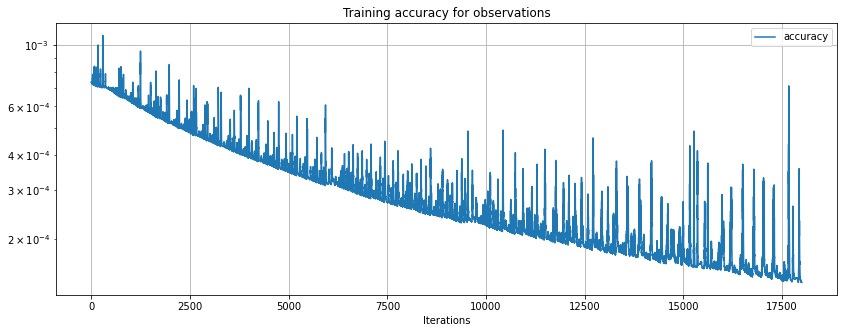

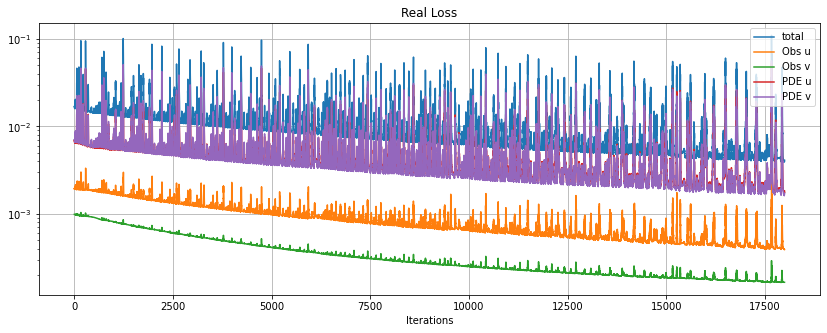

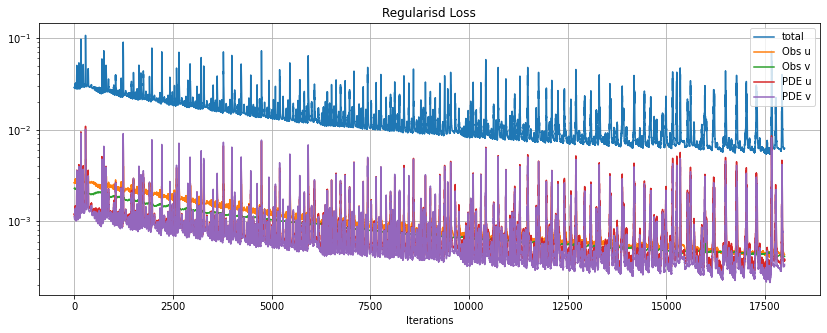

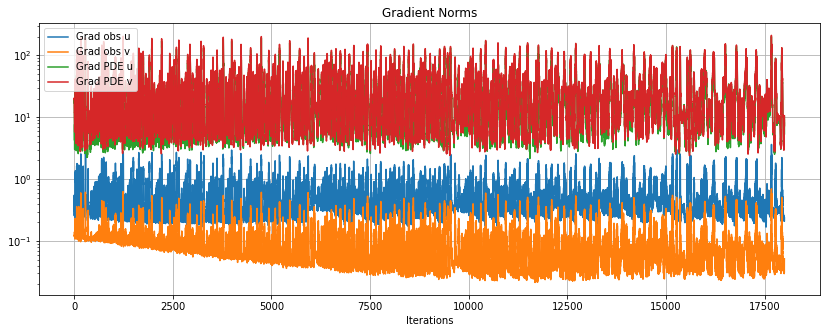

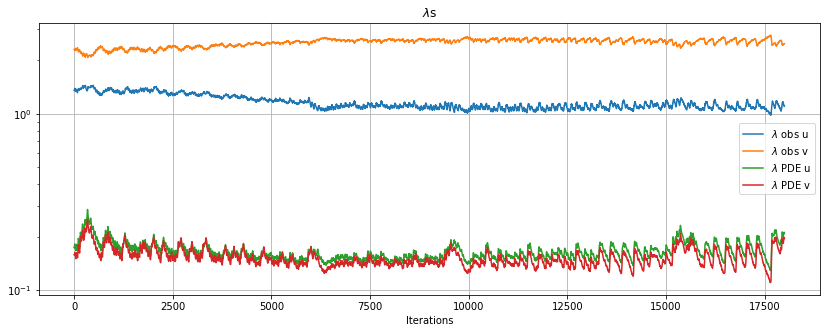

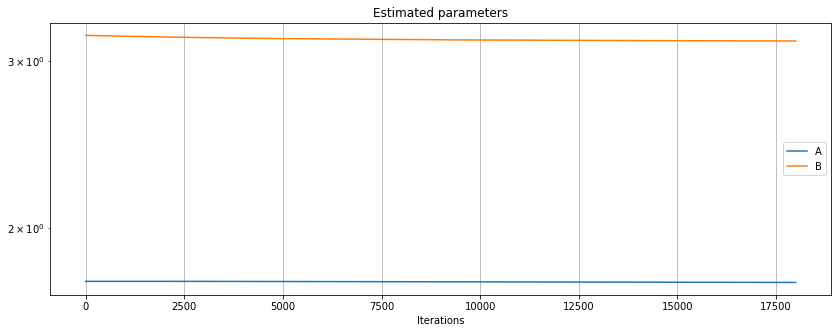

In [103]:
plot_result(results2_5, param_names=["A", "B"])

In [102]:
model2.save("/end/home/rh2310/save_tests", "model_100_by_100_opt")

In [104]:
x_domain = dataset.simulation.L[0] * np.linspace(0, 1, dataset.simulation.n[0])
y_domain = dataset.simulation.L[1] * np.linspace(0, 1, dataset.simulation.n[1])
x_size = dataset.simulation.n[0]
y_size = dataset.simulation.n[1]
N2 = x_size * y_size


T_test_index = -1#119
print(dataset.ts[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(dataset.ts[T_test_index], N2)  # 1 x N2

A_test = np.repeat(dataset.simulation.parameters["A"]+1, N2)
B_test = np.repeat(dataset.simulation.parameters["B"]+1, N2)

512.0


In [105]:
output_test = pinn2(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

In [106]:
import os
data_path = os.path.abspath("../../test/outputs_Brusselator_100_by_100/Brusselator_1/Brusselator_1.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data = data[...,-2:]

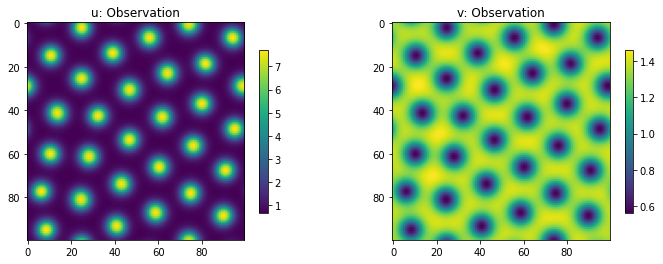

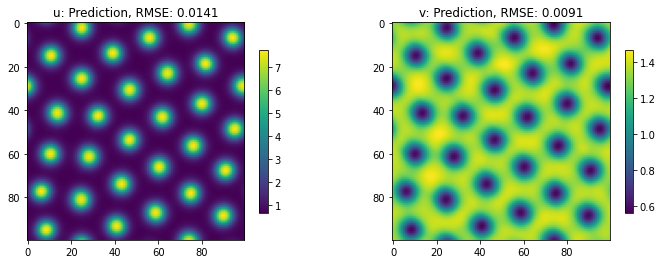

In [107]:
node_names = ["u", "v"]
_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    rmse = np.sqrt(np.mean((output_test[i,:, :] - data[i,:, :, T_test_index])**2))
    plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [108]:
test_outputs, test_pde_u, test_pde_v = pde_loss2.residual(pinn2, np.vstack([XX_test, YY_test, TT_test]).T)
test_outputs = test_outputs.numpy()
test_pde_u = test_pde_u.numpy().reshape((x_size, y_size))
test_pde_v = test_pde_v.numpy().reshape((x_size, y_size))

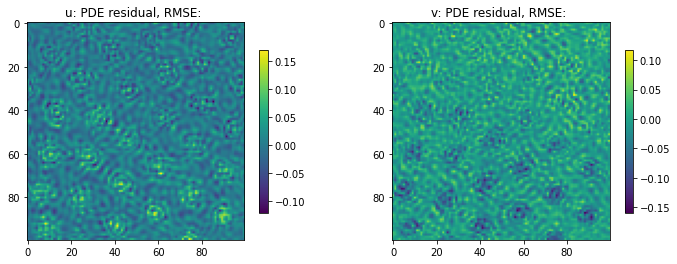

In [109]:
_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title(f"u: PDE residual, RMSE: ")
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
plt.title(f"v: PDE residual, RMSE: ")
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)

plt.show()

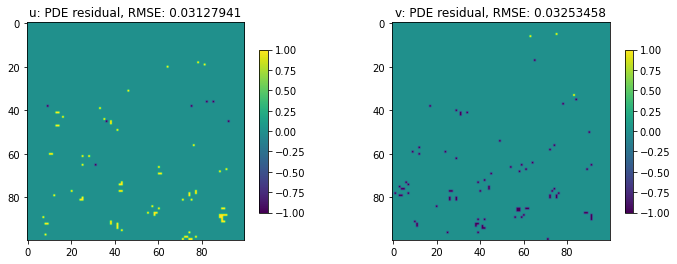

In [110]:
max_L = .10
min_L = -.10

_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)

plt.colorbar(shrink=.75)

plt.show()

# Optimisation Part

In [20]:
from scipy.optimize import minimize

In [111]:
pde_loss_min = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulation.Ds[0],dtype=pinn2.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulation.Ds[1],dtype=pinn2.dtype),
                       A=PDE_Parameter("A", Parameter_Type.VARIABLE,pde_loss2.A.tf_var.numpy()[0] ,dtype=pinn2.dtype),
                       B=PDE_Parameter("B", Parameter_Type.VARIABLE, pde_loss2.B.tf_var.numpy()[0],dtype=pinn2.dtype) 
                       )


In [113]:
inputs = np.vstack([XX_test, YY_test, TT_test]).T
def mini(params):
    A, B = params
    pde_loss_min.A.tf_var.assign([A])
    pde_loss_min.B.tf_var.assign([B])
    _, test_pde_u, test_pde_v = pde_loss_min.residual(pinn2, inputs)
    
    #return np.sum(np.abs(test_pde_u)) + np.sum(np.abs(test_pde_v))
    return np.sum(test_pde_u**2) + np.sum(test_pde_v**2)
    
    

In [114]:
int_AB = (pde_loss2.A.tf_var.numpy()[0], pde_loss2.B.tf_var.numpy()[0])
res = minimize(mini, (int_AB), method='Powell', tol=1e-7)

In [115]:
res

   direc: array([[ 0.00000000e+00,  1.00000000e+00],
       [-2.44847211e-03, -3.41544150e-04]])
     fun: 18.139240874161636
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([1.74975196, 3.14293719])

In [112]:
print(f"A = {pde_loss2.A.tf_var.numpy()[0]:.16f}")
print(f"B = {pde_loss2.B.tf_var.numpy()[0]:.16f}")

A = 1.7536149790719648
B = 3.1473227357100142
